In [2]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import matplotlib.ticker as ticker
import re, glob

# Plot energy norm for IMEX-RB on 2D nonlinear problem
We show absolute stability of IMEX-RB

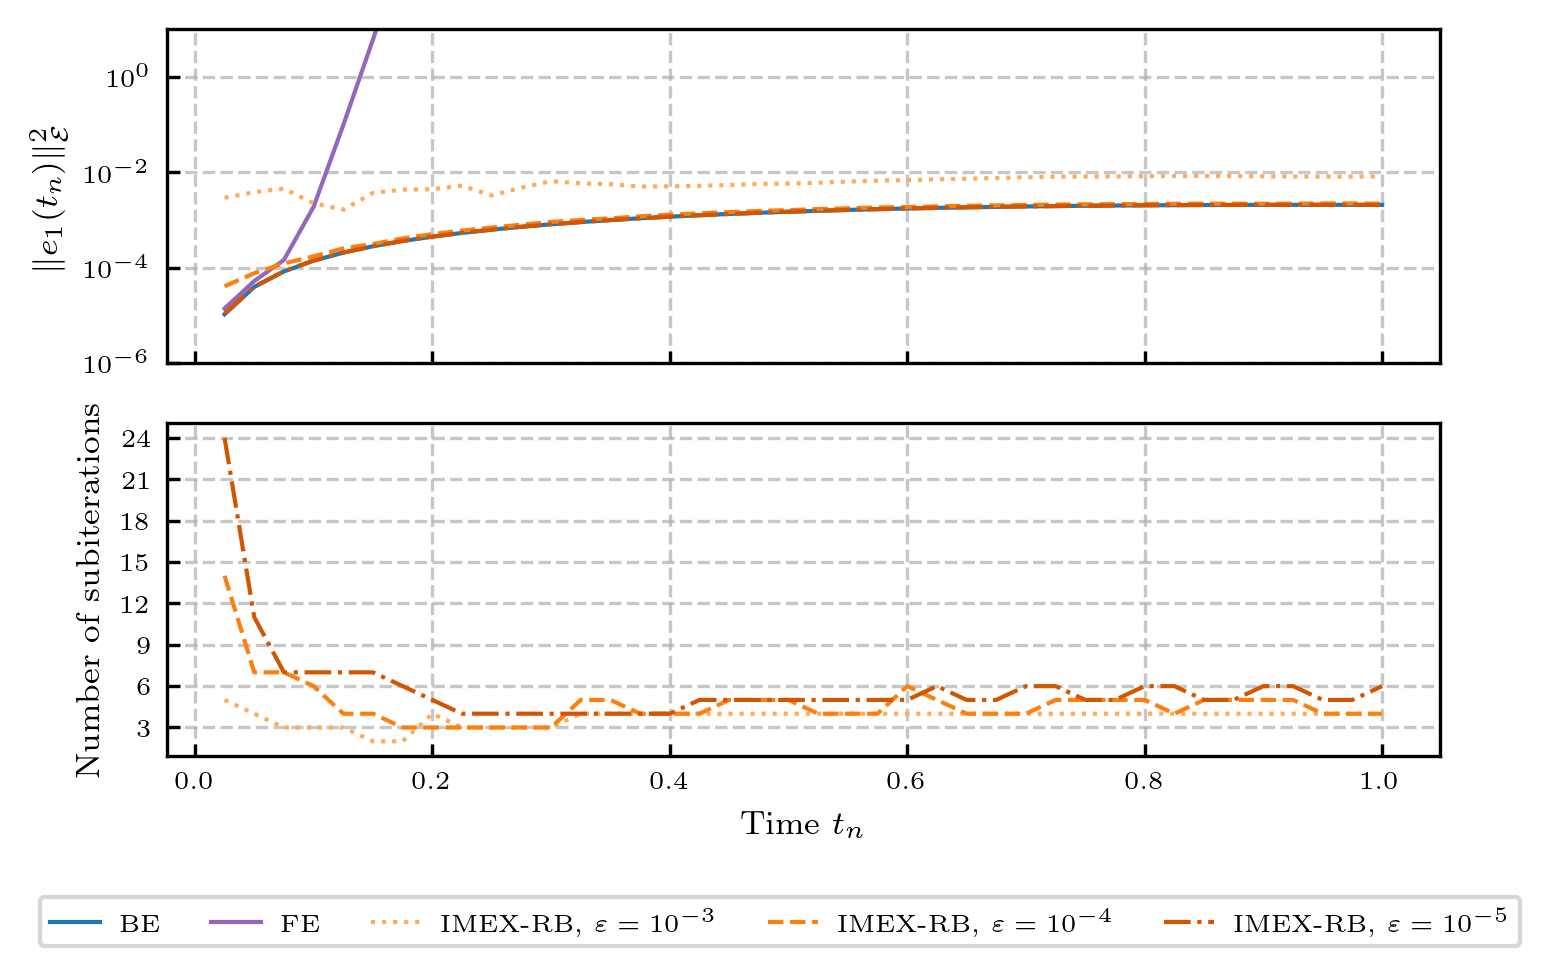

In [3]:
# Define colors
import matplotlib.pyplot as plt
colors = {
    'blue': '#1f77b4',      # Standard matplotlib blue
    'orange': '#ff7f0e',    # Standard matplotlib orange
    'orange_light': '#ffab5c',  # Lighter orange
    'orange_dark': '#d45500',   # Darker orange
    'violet': '#9467bd'       # Standard matplotlib green (next standard color)
}

# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "energynorm"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, 'results', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')
plots_dir  = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_energy = data['errors_energy'].item()   # dict: keys BE, FE, IMEX-RB
subiters      = data['subiters'].item()        # dict: key IMEX-RB
Nt            = int(data['Nt'])
tvec          = np.linspace(0, 1, Nt + 1)

methods      = ['BE', 'FE', 'IMEX-RB']
epsilon_values = data['epsilon_values']

comp_labels = ['u_1']  # or ['u_x','u_y'] if you have two
linestyles  = [':', '--', '-.']
markers     = ['o', 's', 'd']  # one for each ε

# Define color mapping for each method/epsilon
method_colors = {
    'BE': colors['blue'],
    'FE': colors['violet']
}
eps_colors = [colors['orange_light'], colors['orange'], colors['orange_dark']]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3), sharex=True)

# Energy‐error subplot
for ic, comp in enumerate(comp_labels):
    # BE and FE are independent of ε (just one curve each)
    for m in ('BE', 'FE'):
        e = errors_energy[m][ic]
        ax1.semilogy(tvec[1:], e,
                     # linestyle=linestyles[ic],
                     color=method_colors[m],
                     label=f'{m}')

    # IMEX‐RB: one curve per ε
    for ie, eps in enumerate(epsilon_values):
        e = errors_energy['IMEX-RB'][ie, ic]
        expnt = int(np.log10(eps))
        ax1.semilogy(tvec[1:], e,
                     linestyle=linestyles[ie],
                     color=eps_colors[ie],
                     # marker=markers[ie],
                     # markevery=Nt//10,
                     label='') #rf'IMEX-RB $(\varepsilon=10^{{{expnt}}})$')

ax1.set_ylabel(r'$\|e_1(t_n)\|_{\mathcal{E}}^2$')
ax1.set_ylim(1e-6, 1e1)
# ax1.legend(bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=5)
ax1.grid(True)

# Subiters
for ie, eps in enumerate(epsilon_values):
    expnt = int(np.log10(eps))
    label = rf'IMEX-RB, $\varepsilon=10^{{{expnt}}}$'
    its = subiters['IMEX-RB'][ie]
    ax2.plot(tvec[1:], its,
             linestyle=linestyles[ie],
             color=eps_colors[ie],
             # marker=markers[ie],
             # markevery=Nt//10,
             label=label)

ax2.set_xlabel('Time $t_n$')
ax2.set_ylabel('Number of subiterations')
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax2.grid(True)

fig.legend(bbox_to_anchor=(0.53, -0.0), loc='upper center', ncol=5)

plt.tight_layout()
out_file = os.path.join(plots_dir, 'Burgers2D_errors_subiters_eps.pdf')
plt.savefig(out_file, bbox_inches='tight')
plt.show()
plt.close()